# Importation des bibliothèques nécessaires

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import seaborn as sn
from sklearn.model_selection import train_test_split

# Chargements des données

In [30]:
# Constants
IMG_SIZE = 128
BATCH_SIZE = 32

# Fonction pour charger les données
def load_data():
    """Charge les données de malaria depuis tensorflow_datasets"""
    dataset_name = "malaria"
    (train_data, test_data), metadata = tfds.load(
        dataset_name,
        split=["train[:80%]", "train[80%:]"],
        as_supervised=True,
        with_info=True
    )
    return train_data, test_data, metadata

# Charger le dataset avec metadata
(train_dataset, test_dataset, info) = load_data()

# Calculer le nombre d'exemples pour le split
num_train_examples = int(info.splits['train'].num_examples * 0.8)
num_validation_examples = int(info.splits['train'].num_examples * 0.2)

print("Dataset Info:")
print(info)
print(f"Nombre d'exemples dans le dataset d'entraînement: {num_train_examples}")
print(f"Nombre d'exemples dans le dataset de validation: {num_validation_examples}")

Dataset Info:
tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='C:\\Users\\Utilisateur\\tensorflow_datasets\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria paras

# Préparation des données

Visualisation des exemples du dataset d'entraînement:


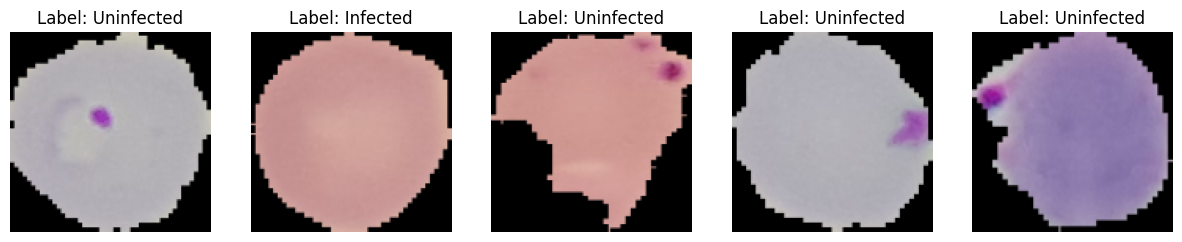

In [31]:
# Prétraitement des données
def preprocess(image, label):
    """Redimensionne et normalise les images"""
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0  # Normalisation entre 0 et 1
    return image, label

train_dataset = train_dataset.map(preprocess).batch(BATCH_SIZE).shuffle(1000)
test_dataset = test_dataset.map(preprocess).batch(BATCH_SIZE)

# Visualisation de quelques exemples
def visualize_data(dataset, num_images=5):
    """Affiche quelques exemples du dataset"""
    plt.figure(figsize=(15, 15))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(image.numpy())
        plt.title(f"Label: {'Infected' if label.numpy() == 1 else 'Uninfected'}")
        plt.axis('off')
    plt.show()

print("Visualisation des exemples du dataset d'entraînement:")
visualize_data(train_dataset.unbatch())

# Construction et compilation du modèle

In [32]:

# Créer le modèle CNN
model = tf.keras.Sequential([
tf.keras.Input(shape=(128, 128, 3)),  # Taille de l'image 128x128 avec 3 canaux couleur (RGB)
tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),  # Première couche convolutionnelle
tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  # Pooling pour réduire la taille de l'image

tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),  # Deuxième couche convolutionnelle
tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  # Pooling pour réduire la taille de l'image

tf.keras.layers.Flatten(),  # Flatten pour transformer les données en vecteur
tf.keras.layers.Dropout(0.7),  # Dropout pour éviter le surapprentissage

tf.keras.layers.Dense(128, activation='relu'),  # Couche dense avec activation ReLU
tf.keras.layers.Dense(1, activation='sigmoid')  # Couche de sortie pour la classification binaire
    ])

    # Compiler le modèle
model.compile(optimizer='adam',  # Optimiseur Adam
            loss='binary_crossentropy',  # Fonction de perte pour une classification binaire
            metrics=['accuracy', 'precision', 'recall'])  # Métriques à surveiller


# Afficher le résumé du modèle
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,449 (28.20 MB)

 Trainable params: 7,392,449 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

# Entraînement du modèle

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 244s 347ms/step - accuracy: 0.6256 - loss: 0.6511 - precision: 0.6147 - recall: 0.7234 - val_accuracy: 0.9156 - val_loss: 0.2481 - val_precision: 0.8846 - val_recall: 0.9542
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 282s 400ms/step - accuracy: 0.9213 - loss: 0.2293 - precision: 0.9036 - recall: 0.9420 - val_accuracy: 0.9267 - val_loss: 0.2373 - val_precision: 0.8922 - val_recall: 0.9693
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 261s 371ms/step - accuracy: 0.9362 - loss: 0.1950 - precision: 0.9152 - recall: 0.9615 - val_accuracy: 0.9390 - val_loss: 0.2019 - val_precision: 0.9067 - val_recall: 0.9777
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 259s 368ms/step - accuracy: 0.9464 - loss: 0.1643 - precision: 0.9318 - recall: 0.9645 - val_accuracy: 0.9376 - val_loss: 0.2020 - val_precision: 0.9117 - val_recall: 0.9678
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 255s 361ms/step - accuracy: 0.9513 - loss: 0.1467 - precision: 0.9409 - recall: 0.9636 - val_accuracy: 0

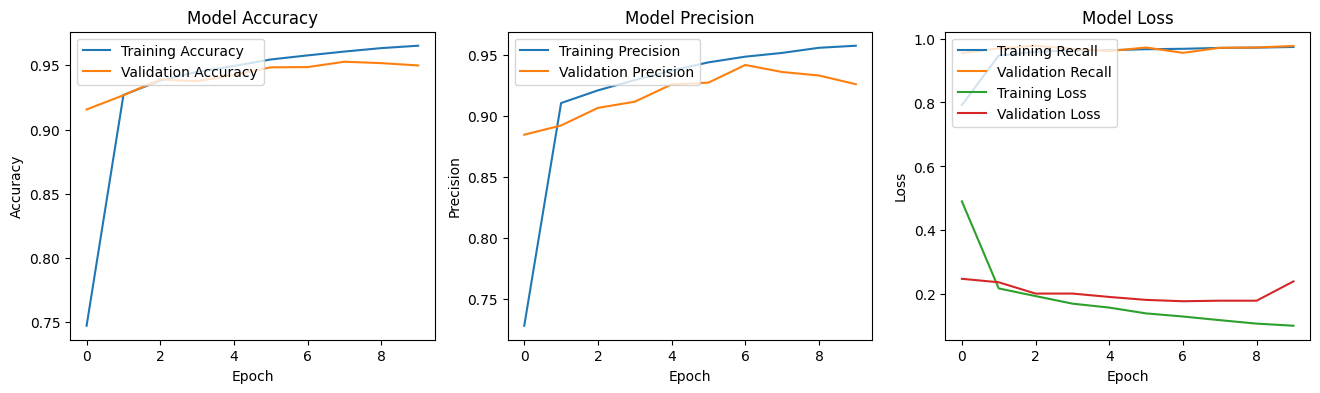

In [5]:
# Préparer les données
train_dataset, validation_dataset = train_dataset, test_dataset

# Entraîner le modèle
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

# Visualiser l'évolution des performances
plt.figure(figsize=(16, 4))

# Accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Precision
plt.subplot(1, 3, 2)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(loc='upper left')

# Recall
plt.subplot(1, 3, 3)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(loc='upper left')

# Loss
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

In [7]:
import keras.saving

keras.saving.save_model(model, "/app/model/malaria_model.keras")

# Visualisations de quelques prédictions

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

model = tf.keras.models.load_model("/app/model/malaria_model.keras")


# Prédictions
predictions = np.concatenate([model.predict(batch[0]) for batch in test_dataset], axis=0)
true_classes = np.concatenate([batch[1].numpy() for batch in test_dataset], axis=0)

# Matrice de confusion
confusion_mat = confusion_matrix(np.argmax(true_classes, axis=1), np.argmax(predictions, axis=1))
print("Matrice de confusion :")
print(confusion_mat)

# Rapport de classification
classification_rep = classification_report(np.argmax(true_classes, axis=1), np.argmax(predictions, axis=1))
print("Rapport de classification :")
print(classification_rep)


# Visualisation des erreurs
errors = np.where(np.argmax(predictions, axis=1) != np.argmax(true_classes, axis=1))[0]
plt.figure(figsize=(15, 15))
for i, idx in enumerate(errors[:9]):  # Limitez le nombre d'exemples à visualiser pour éviter un affichage trop dense
    image, true_label = list(test_dataset.unbatch())[idx]  # Accédez aux données du test_dataset
    plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy(), cmap="gray")
    plt.title(f"Vrai : {true_label}, Prédit : {np.argmax(predictions[idx])}")
    plt.axis("off")

plt.show()

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [30,128,128,3], [batch]: [32,128,128,3] [Op:IteratorGetNext] name: 

In [65]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Charger le modèle
model = tf.keras.models.load_model("/app/model/malaria_model.keras")

# Prédictions
predictions = np.concatenate([model.predict(batch[0]) for batch in test_dataset], axis=0)
true_classes = np.concatenate([batch[1].numpy() for batch in test_dataset], axis=0)

# Transforme les probabilités en classes prédites
y_pred = np.round(predictions)  # Utilisation d'un seuil à 0.5 pour la prédiction binaire
y_true = np.argmax(true_classes, axis=1)

# Matrice de confusion
confusion_mat = confusion_matrix(y_true, y_pred)
print("Matrice de confusion :")
print(confusion_mat)

# Visualisation de la matrice de confusion
disb = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['Parasitized', 'Uninfected'])
disb.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Rapport de classification
classification_rep = classification_report(y_true, y_pred)
print("Rapport de classification :")
print(classification_rep)

# Visualisation des erreurs
errors = np.where(y_pred != y_true)[0]
plt.figure(figsize=(15, 15))
for i, idx in enumerate(errors[:9]):  # Limitez le nombre d'exemples à visualiser pour éviter un affichage trop dense
    image, true_label = list(test_dataset.unbatch())[idx]  # Accédez aux données du test_dataset
    plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy(), cmap="gray")
    plt.title(f"Vrai : {true_label}, Prédit : {y_pred[idx]}")
    plt.axis("off")

plt.show()

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [30,128,128,3], [batch]: [32,128,128,3] [Op:IteratorGetNext] name: 

In [67]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Charger le modèle
model = tf.keras.models.load_model("/app/model/malaria_model.keras")

# Préparation des données
true_classes = np.concatenate([batch[1].numpy() for batch in test_dataset], axis=0)

# Correction de la forme des données avant prédiction
images = np.concatenate([batch[0] for batch in test_dataset], axis=0)  # Utilisation de la concaténation
images = tf.image.resize(images, (128, 128, 3))  # Redimensionner les images si nécessaire

# Prédictions
predictions = model.predict(images)

# Transforme les probabilités en classes prédites
y_pred = np.round(predictions)  # Utilisation d'un seuil à 0.5 pour la prédiction binaire
y_true = np.argmax(true_classes, axis=1)

# Matrice de confusion
confusion_mat = confusion_matrix(y_true, y_pred)
print("Matrice de confusion :")
print(confusion_mat)

# Visualisation de la matrice de confusion
disb = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['Parasitized', 'Uninfected'])
disb.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Rapport de classification
classification_rep = classification_report(y_true, y_pred)
print("Rapport de classification :")
print(classification_rep)

# Visualisation des erreurs
errors = np.where(y_pred != y_true)[0]
plt.figure(figsize=(15, 15))
for i, idx in enumerate(errors[:9]):  # Limitez le nombre d'exemples à visualiser pour éviter un affichage trop dense
    image, true_label = list(test_dataset.unbatch())[idx]  # Accédez aux données du test_dataset
    plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy(), cmap="gray")
    plt.title(f"Vrai : {true_label}, Prédit : {y_pred[idx]}")
    plt.axis("off")

plt.show()

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [30,128,128,3], [batch]: [32,128,128,3] [Op:IteratorGetNext] name: 